In [92]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os

In [93]:
torch.cuda.is_available()

True

In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [95]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Generate dataset using the second derivative instead of the first

The code currently loads a previously created dataset instead of creating a new one each time.

In [96]:
class FourierSeriesDataset(Dataset):
    def __init__(self, num_samples, num_points, max_terms=10):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_terms = max_terms
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.second_derivatives = self.generate_data()

    def generate_data(self):
        functions = []
        second_derivatives = []

        for _ in range(self.num_samples):
            # Generate random complex coefficients
            n_terms = np.random.randint(1, self.max_terms + 1)
            c = torch.complex(torch.randn(2*n_terms+1), torch.randn(2*n_terms+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            functions.append(y.detach().numpy())

            # Compute derivative
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

            d2y_dx2 = torch.autograd.grad(outputs=dy_dx, inputs=self.x, grad_outputs=torch.ones_like(dy_dx), create_graph=True)[0]
            second_derivatives.append(d2y_dx2.detach().numpy())

        return np.array(functions), np.array(second_derivatives)

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        n_terms = (len(c) - 1) // 2
        for n in range(-n_terms, n_terms+1):
            result += c[n + len(c)//2] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.FloatTensor(self.functions[idx]), torch.FloatTensor(self.second_derivatives[idx])

# Generate dataset
num_samples = 10000
num_points = 1000
# dataset = FourierSeriesDataset(num_samples, num_points)

# # Create DataLoader
# batch_size = 32
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# torch.save(dataset, 'second_derivative_dataset.pt')

## Load previously saved dataset

In [97]:
# dataset = torch.load('derivative_dataset.pt')
# to use the cluster dataset, use:
dataset = torch.load('second_derivative_dataset.pt')

In [98]:
from torch.utils.data import random_split
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

In [99]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [100]:
print(len(train_dataloader))
print(len(test_dataloader))

250
62


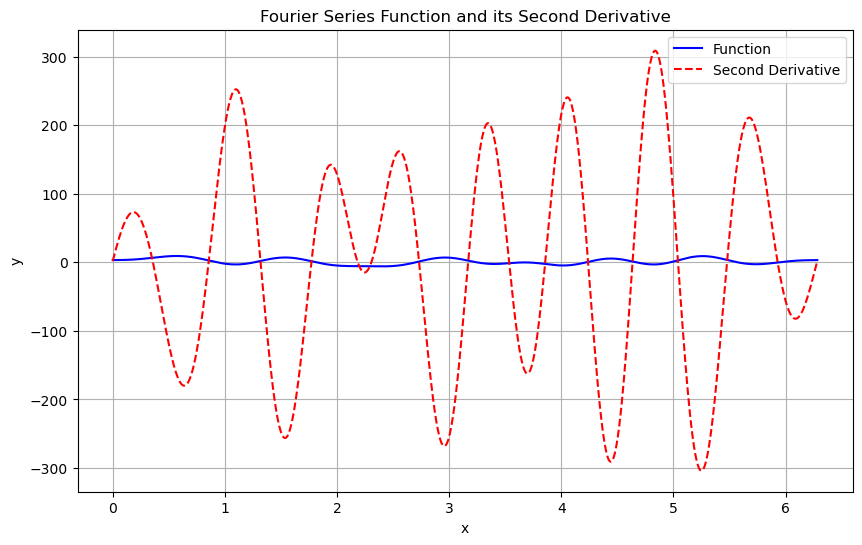

In [101]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    plt.plot(x, derivative, label='Second Derivative', color='red', linestyle='--')
    
    plt.title('Fourier Series Function and its Second Derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example usage:
# Assuming you have already created your dataset and dataloader as before
# dataset = FourierSeriesDataset(num_samples, num_points)

def get_random_function(shuffle=True):
    return DataLoader(train_dataset, batch_size=1, shuffle=shuffle)

train_dataloader_viz = get_random_function(shuffle=False)
plot_function_and_derivative(train_dataloader_viz)

## Model Training

Create the model

In [102]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Initialize the model, loss function, and optimizer
model1 = SimpleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters())

## Load in previously saved model weights from 300 epochs

In [103]:
# model1.load_state_dict(torch.load('model_weights.pth'))
# to use model from cluster, change this to 
model1.load_state_dict(torch.load('first_stage_1000epochs_second_derivative_weights.pth'))


<All keys matched successfully>

## Training loop

In [104]:
# Training loop
train_losses = []
test_losses = []

def first_stage_training(num_epochs):
    for epoch in range(num_epochs):
        model1.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives in train_dataloader:
            # Reshape input: [batch_size, 1, num_points]
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            # Forward pass
            outputs = model1(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model1.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model1(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print("Training finished!")


# Save the model
# Don't save the model right now

# first_stage_training(400)
# torch.save(model1.state_dict(), 'first_stage_400epochs_second_derivative_weights.pth')

In [105]:
def plot_losses(train_losses, test_losses, save_dir='plots', xmin=None, ymax=None, filename=None):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # if xmin:
    #     plt.xlim(xmin=xmin)
    #     min_loss = min(min(train_losses[xmin-1:]), min(test_losses[xmin-1:]))
    #     max_loss = max(max(train_losses[xmin-1:]), max(test_losses[xmin-1:]))
    #     plt.ylim(min_loss, max_loss)
    # if ymax:
    #     plt.ylim(ymax=ymax)
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path)    
    plt.show()

In [123]:
# plot_losses(train_losses=train_losses, test_losses=test_losses, filename='first_stage_second_derivative_loss')

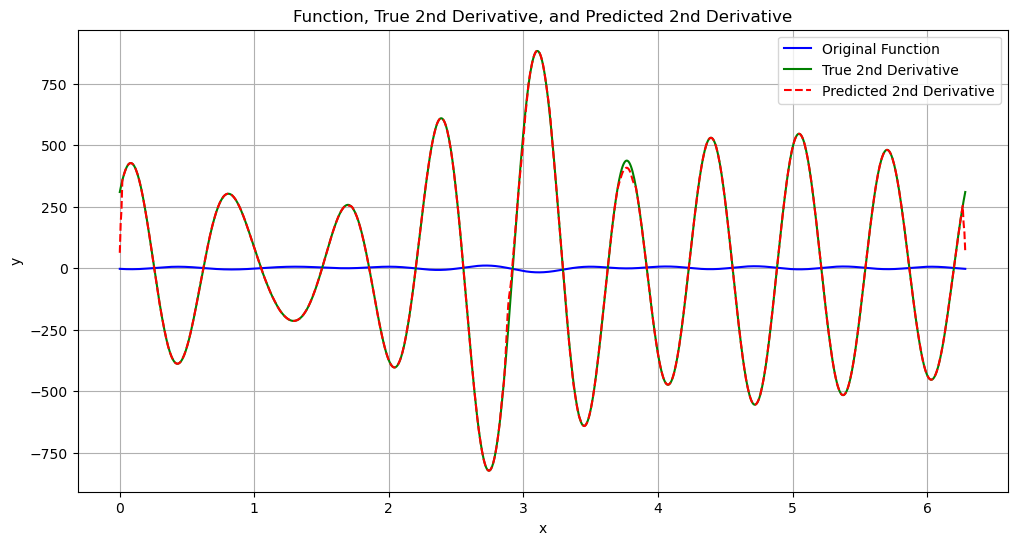

In [107]:
model1.eval()  # Set the model to evaluation mode

train_dataloader_viz = get_random_function(shuffle=True)
# Get a random sample from the dataloader
dataiter = iter(train_dataloader_viz)
function, true_derivative = next(dataiter)

# Reshape the input for the model
function = function.unsqueeze(1)  # Add channel dimension

# Make prediction
with torch.no_grad():
    predicted_derivative = model1(function)

# Convert tensors to numpy arrays for plotting
x = torch.linspace(0, 2*torch.pi, 1000).numpy()
function = function.squeeze().numpy()
true_derivative = true_derivative.squeeze().numpy()
predicted_derivative = predicted_derivative.squeeze().numpy()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(x, function, label='Original Function', color='blue')
plt.plot(x, true_derivative, label='True 2nd Derivative', color='green')
plt.plot(x, predicted_derivative, label='Predicted 2nd Derivative', color='red', linestyle='--')
plt.title('Function, True 2nd Derivative, and Predicted 2nd Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [108]:
smallest_five = heapq.nsmallest(5, test_losses)
smallest_five

[]

## Multi-stage component: first correction network
This is the second network in the function, but the first "correction" network.
Uses normalized data, $\left(x_i, \frac{e_i(x_i)}{\epsilon_i}\right)$

In [109]:
def compute_normalized_residual(model, dataloader):
    model.eval() # model1 is the trained first stage network
    residuals = []
    with torch.no_grad():
        for batch_functions, batch_derivatives in dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            outputs = model1(batch_functions) # compute the first stage network outputs
            
            outputs = outputs.squeeze() # remove the extra batch dimension after model has computed outputs
            residual = outputs - batch_derivatives # computing the difference between predicted derivative and true derivative
            # residual is a vector that should have shape 32,1000
            residuals.append(residual)
            
    residuals = torch.cat(residuals, dim=0)
    rms = torch.sqrt(torch.mean(residuals**2))
    normalized_residuals = residuals / rms
    return normalized_residuals, rms

In [110]:
class ResidualDataset(Dataset):
    def __init__(self, original_dataset, residuals):
        self.original_dataset = original_dataset
        self.residuals = residuals

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        function, _ = self.original_dataset[idx]
        return function, self.residuals[idx]

## Residual CNN

In [111]:
class ResidualCNN(nn.Module):
    def __init__(self):
        super(ResidualCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [112]:
# Compute normalized residuals
# This uses the first stage network ("model" corresponds to the first stage of training)
train_residuals, train_rms = compute_normalized_residual(model1, train_dataloader)
test_residuals, test_rms = compute_normalized_residual(model1, test_dataloader)

# Create residual datasets: this contains the original functions and their residuals from the first stage
residual_train_dataset = ResidualDataset(train_dataset, train_residuals)
residual_test_dataset = ResidualDataset(test_dataset, test_residuals)

# Create dataloaders for residual data
residual_train_loader = DataLoader(residual_train_dataset, batch_size=32, shuffle=True)
residual_test_loader = DataLoader(residual_test_dataset, batch_size=32, shuffle=False, drop_last=True)

# Initialize the residual model, loss function, and optimizer
residual_model = ResidualCNN()

residual_criterion = nn.MSELoss()
residual_optimizer = optim.Adam(residual_model.parameters())

In [113]:
residual_model.load_state_dict(torch.load('second_stage_1000epochs_second_derivative_weights.pth'))

<All keys matched successfully>

In [114]:
# # Training loop for residual model
# train_losses2 = []
# test_losses2 = []

# num_epochs = 400
# for epoch in range(num_epochs):
#     residual_model.train()
#     train_loss = 0.0
#     test_loss = 0.0

#     for batch_functions, batch_residuals in residual_train_loader:

#         outputs = residual_model(batch_functions.unsqueeze(1))
#         loss = residual_criterion(outputs, batch_residuals.unsqueeze(1))

#         residual_optimizer.zero_grad()
#         loss.backward()
#         residual_optimizer.step()
#         train_loss += loss.item()

#     train_loss /= len(residual_train_loader)

#     residual_model.eval()
#     with torch.no_grad():
#         for batch_functions, batch_residuals in residual_test_loader:
#             outputs = residual_model(batch_functions.unsqueeze(1))
#             loss = residual_criterion(outputs, batch_residuals.unsqueeze(1))
#             test_loss += loss.item()

#     test_loss /= len(residual_test_loader)

#     print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
#     train_losses2.append(train_loss)
#     test_losses2.append(test_loss)


# # Save the residual model
# # Don't save the residual model right now
# torch.save(residual_model.state_dict(), 'second_stage_400epochs_second_derivative_weights.pth')

# print("Residual model training finished!")

Comment out for testing

In [115]:
# plot_losses(train_losses=train_losses2, test_losses=test_losses2, filename='second_stage_second_derivative_loss')

Something is not right about how I am training on the residuals

In [116]:
def plot_combined_model_output(model1, model2, filename=None):
    model1.eval()  # Set the model to evaluation mode
    model2.eval()

    save_dir = 'plots'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    train_dataloader_viz = get_random_function(shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        predicted_derivative1 = model1(function)

        residual = predicted_derivative1.squeeze() - true_derivative
        rms = torch.sqrt(torch.mean(residual**2))
        
        predicted_derivative2 = model2(function)
        combined_model_output = predicted_derivative1 + rms * predicted_derivative2

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()
    true_derivative = true_derivative.squeeze().numpy()
    predicted_derivative = combined_model_output.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(x, function, label='Original Function', color='blue')
    plt.plot(x, true_derivative, label='True Derivative', color='green')
    plt.plot(x, predicted_derivative, label='Predicted Derivative', color='red', linestyle='--')
    plt.title('Function, True Derivative, and Predicted Derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path)
    plt.show()

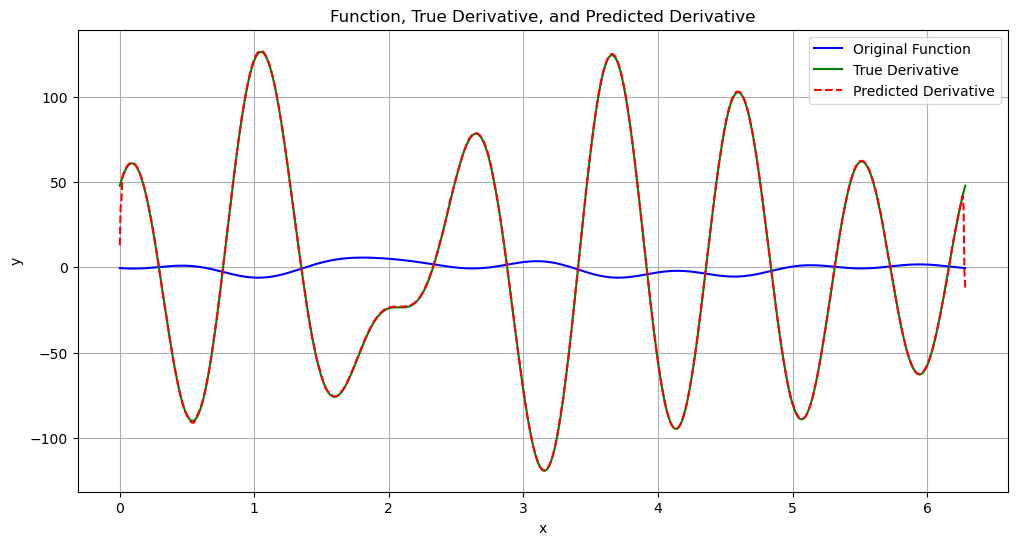

In [117]:
plot_combined_model_output(model1, residual_model, filename='combined_model_output')

## Calculate accuracy (MSE)

In [118]:
def calculate_combined_output(model1, model2, function_input, true_derivative):
    # Predict the derivative from the first model
    predicted_derivative1 = model1(function_input)

    # Compute the residual and root mean squared error
    residual = predicted_derivative1.squeeze() - true_derivative
    rms = torch.sqrt(torch.mean(residual**2))

    # Predict the derivative from the second model
    predicted_derivative2 = model2(function_input)

    # Calculate the combined model output
    combined_model_output = predicted_derivative1 + rms * predicted_derivative2

    return combined_model_output

In [119]:
def compute_mse(dataloader, model1, model2=None):
    model1.eval()

    mse_accumulator = 0.0
    n_batches = 0

    for x, y in dataloader:
        x = x.unsqueeze(1)
        y = y.unsqueeze(1)
        if model2:
            model_output = calculate_combined_output(model1, model2, x, y)
        else:
            model_output = model1(x)
        mse = torch.mean((model_output - y) ** 2, dim=2)  # Assuming output and target are already properly shaped
        mse_accumulator += mse.mean().item()  # Sum up MSE and convert to Python float
        n_batches += 1

    overall_mse = mse_accumulator / n_batches
    print(f"Overall MSE over all test functions: {overall_mse}")
    return overall_mse

# Example usage:
compute_mse(test_dataloader, model1, model2=residual_model)

Overall MSE over all test functions: 199.7743677939138


199.7743677939138

MSE for second stage is much higher than I expect

In [120]:
compute_mse(test_dataloader, model1)

Overall MSE over all test functions: 20.62893441415602


20.62893441415602

## Spectral biases from Fourier Transform

In [121]:
# Get the output of the trained model
model1.eval()
with torch.no_grad():
    for x, y in train_dataloader:
        x = x.unsqueeze(1)
        y = y.unsqueeze(1)
        output = model1(x)
        break  # Use the first batch for simplicity

# Compute the Fourier transform of the output
output_np = output.numpy().squeeze(1)
output_fft = np.fft.fft(output_np, axis=1)

# Compute the Fourier transform of the true function
y_np = y.numpy().squeeze(1)
y_fft = np.fft.fft(y_np, axis=1)

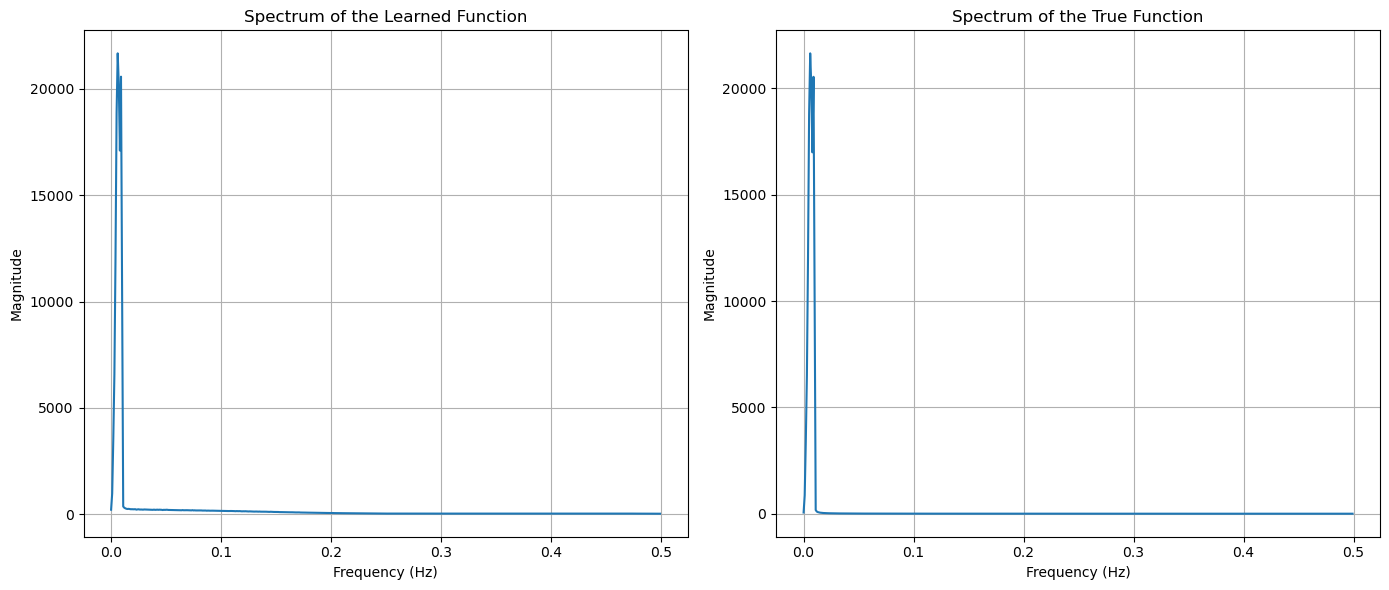

In [122]:
# Squeeze out unnecessary dimensions
output_np = output_np
y_np = y_np

# Compute the Fourier transform of the outputs
output_fft = np.fft.fft(output_np, axis=1)
y_fft = np.fft.fft(y_np, axis=1)

# Compute the magnitude of the FFT and average over all samples
output_fft_magnitude = np.abs(output_fft).mean(axis=0)
y_fft_magnitude = np.abs(y_fft).mean(axis=0)

# Calculate the frequency bins
num_samples = output_np.shape[-1]
frequency_bins = np.fft.fftfreq(num_samples, d=1.0)  # Assuming unit sampling rate for simplicity

# Only take the first half of the frequency bins and magnitude spectrum due to symmetry in FFT of real signals
half_index = num_samples // 2
frequency_bins = frequency_bins[:half_index]
output_fft_magnitude = output_fft_magnitude[:half_index]
y_fft_magnitude = y_fft_magnitude[:half_index]

# Plotting
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title('Spectrum of the Learned Function')
plt.plot(frequency_bins, output_fft_magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Spectrum of the True Function')
plt.plot(frequency_bins, y_fft_magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)

plt.tight_layout()
plt.show()